## Transfer Learning using VGG16

In [20]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.8 MB/s eta 0:00:00


### Loading the Libraries

In [40]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Flatten, InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
import pickle

from PIL import Image, ImageFont, ImageDraw
import glob
import os, shutil
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns
import visualkeras
from tabulate import tabulate
import time
import matplotlib.pyplot as plt
import numpy as np


### Data Acquisition

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download "mengcius/cinic10"


In [ ]:
!unzip \*.zip  && rm *.zip

In [43]:
cinic_dir = '/content'
traindir = cinic_dir + '/train'
validatedir = cinic_dir + '/valid'
testdir = cinic_dir + '/test'

### Data Augmentation and Splitting*

*In CINIC-10 the data is already split for Training, Validation and Testing Sets

In [44]:
img_height,img_width=32,32
batch_size=128
train_time = []
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Training Set without augmentation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  traindir,
  label_mode="categorical",
  seed=524,
  image_size = (img_height,img_width),
  batch_size=batch_size)

#Training Set with augmentation
train_ds_augmented = datagen.flow_from_directory(
    traindir,
    target_size = (img_height,img_width),
    seed = 524,
    batch_size=batch_size,
    class_mode='categorical')

#Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validatedir,
  label_mode="categorical",
  seed=524,
  image_size = (img_height,img_width),
  batch_size=batch_size)

#Test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testdir,
  label_mode="categorical",
  image_size = (img_height,img_width),
  seed=524,
  batch_size=batch_size)

Found 90000 files belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.


### Model Architecture Visualizing

In [45]:

def architecture(m1, m2, name1, name2):
  font_path = '/content/Arial.ttf'
  font = ImageFont.truetype(font_path, 22)
  color_map = defaultdict(dict)
  color_map[Conv2D]['fill'] = 'orange'
  color_map[Dropout]['fill'] = 'pink'
  color_map[MaxPooling2D]['fill'] = 'red'
  color_map[GlobalAveragePooling2D]['fill'] = 'purple'
  color_map[Dense]['fill'] = 'gray'
  color_map[Flatten]['fill'] = 'teal'
  color_map[BatchNormalization]['fill'] = 'yellow'
  color_map[InputLayer]['fill'] = 'cyan'

  visualkeras.layered_view(m1,color_map=color_map, legend=True, font=font, to_file=f'/content/{name1}.png')
  visualkeras.layered_view(m2, color_map=color_map, legend=True, font=font, to_file=f'/content/{name2}.png')

  image1 = Image.open(f'/content/{name1}.png')
  image2 = Image.open(f'/content/{name2}.png')
  width = max(image1.width, image2.width)


  concatenated_image = Image.fromarray(np.ones((image1.height + image2.height, width, 3), dtype=np.uint8) * 255)
  concatenated_image.paste(image1, (0, 0))
  concatenated_image.paste(image2, (0, image1.height))
  fig, ax = plt.subplots()
  ax.imshow(concatenated_image)
  ax.axis('off')
  plt.show()



## I have made 4 different alternatives on Pre Trained VGG model for analysis

* ### Model 1 :  VGG with untrainable Convolutional Layers   
* ### Model 2 :  VGG and with untrainable Convolutional Layers with Data Augmentation
* ### Model 3 : VGG with untrainable Convolutional layers with Data Augmentation and Regularization with Batch Normalization and Dropout Layers
* ### Model 4 : Fully trainable VGG with Data Augmentation

## Model 1

### Load Pretrained VGG Model

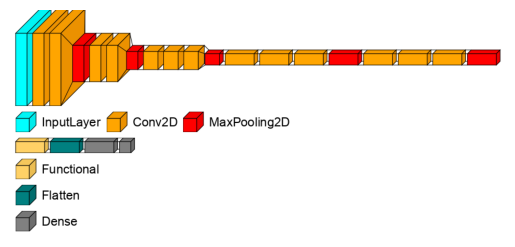

In [46]:
#m1 Untrainable Conv Layer

vgg_model_1 = Sequential()
pretrained_model_1= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_1.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_1.input
output = pretrained_model_1.layers[-2].output
pre_model_1 = Model(inputs=new_input, outputs=output)

# Adding the custom Classifying Dense Layers (without any regularization)
vgg_model_1.add(pre_model_1)
vgg_model_1.add(Flatten())
vgg_model_1.add(Dense(512, activation='relu'))
vgg_model_1.add(Dense(10, activation='softmax'))

# pre_model_1.summary()
# vgg_model_1.summary()
architecture(pre_model_1, vgg_model_1, "m1_p1", "m1_p2")


### Training Model 1

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_1 = vgg_model_1.fit(train_ds, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))
train_time[0] = (time.time() - start_time)

Epoch 1/55
704/704 [==============================] - ETA: 0s - loss: 2.6818 - accuracy: 0.4053

### Saving Model and History (Evaluation Metrics)*

*Can load the model(.h5) or history(.pkl) file for further analysis

In [ ]:
# To save the model and history
vgg_model_1.save("vgg_model_1.h5")
with open('history_1.pkl', 'wb') as file:
    pickle.dump(history_1.history, file)

#To load the model
# vgg_model_1 = load_model("vgg_model_1.h5")
# with open('history_1.pkl', 'rb') as file:
#   history_1 = pickle.load(file)

## Model 2

### Load Pretrained VGG Model

In [ ]:
# m2 VGG and with untrainable Conv Layers with Data Augmentation
#The model is same as m1 but we just use data augmentation during training

vgg_model_2 = Sequential()
pretrained_model_2= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_2.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_2.input
output = pretrained_model_2.layers[-2].output
pre_model_2 = Model(inputs=new_input, outputs=output)

# Adding the custom Classifying Dense Layers (without any regularization)
vgg_model_2.add(pre_model_1)
vgg_model_2.add(Flatten())
vgg_model_2.add(Dense(512, activation='relu'))
vgg_model_2.add(Dense(10, activation='softmax'))

# pre_model_2.summary()
# vgg_model_2.summary()
architecture(pre_model_2, vgg_model_2, "m2_p1", "m2_p2")


### Training Model 2

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_2 = vgg_model_2.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))
train_time[1] = (time.time() - start_time)

### Saving Model and History

In [ ]:
# To save the model and history
vgg_model_2.save("vgg_model_2.h5")
with open('history_2.pkl', 'wb') as file:
    pickle.dump(history_2.history, file)

#To load the model
# vgg_model_2 = load_model("vgg_model_2.h5")
# with open('history_2.pkl', 'rb') as file:
#   history_2 = pickle.load(file)

## Model 3

### Load Pretrained VGG Model

In [ ]:
# m3 VGG with untrainable conv layers with Data Augmentation and
#Regularization with Batch Normalization and Dropout Layers

vgg_model_3 = Sequential()

pretrained_model_3= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model_3.layers:
        layer.trainable=False

# Removing Avg Max Pooling
new_input = pretrained_model_3.input
output = pretrained_model_3.layers[-2].output
pre_model_3 = Model(inputs=new_input, outputs=output)

vgg_model_3.add(pre_model_3)
vgg_model_3.add(BatchNormalization())
vgg_model_3.add(Flatten())
vgg_model_3.add(Dense(512, activation='relu'))
vgg_model_3.add(BatchNormalization())
vgg_model_3.add(Dropout(0.2))
vgg_model_3.add(Dense(10, activation='softmax'))

# pre_model_3.summary()
# vgg_model_3.summary()
architecture(pre_model_3, vgg_model_3, "m3_p1", "m3_p2")

### Training Model 3

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_3 = vgg_model_3.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))
train_time[2] = (time.time() - start_time)

### Saving Model and History

In [ ]:
# To save the model and history
vgg_model_3.save("vgg_model_3.h5")
with open('history_3.pkl', 'wb') as file:
    pickle.dump(history_3.history, file)

#To load the model
# vgg_model_3 = load_model("vgg_model_3.h5")
# with open('history_3.pkl', 'rb') as file:
#   history_3 = pickle.load(file)

## Model 4

### Load Pretrained VGG Model

In [ ]:
#m4 Fully trainable VGG with Data Augmentation & no Regularization layers used

vgg_model_4 = Sequential()

pretrained_model_4= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=10,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

# Removing Avg Max Pooling
new_input = pretrained_model_4.input
output = pretrained_model_4.layers[-2].output
pre_model_4 = Model(inputs=new_input, outputs=output)

vgg_model_4.add(pretrained_model)
vgg_model_4.add(Flatten())
vgg_model_4.add(Dense(512, activation='relu'))
vgg_model_4.add(Dense(10, activation='softmax'))


# pre_model_4.summary()
# vgg_model_4.summary()
architecture(pre_model_4, vgg_model_4, "m4_p1", "m4_p2")

### Training Model 4

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
vgg_model_4.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()
history_4 = vgg_model_4.fit(train_ds_augmented, validation_data=val_ds, epochs=55, callbacks=[es])
print("--- %s seconds ---" % (time.time() - start_time))
train_time[3] = (time.time() - start_time)

### Saving Model and History

In [3]:
# To save the model and history
vgg_model_4.save("vgg_model_4.h5")
with open('history_4.pkl', 'wb') as file:
    pickle.dump(history_4.history, file)

#To load the model
# vgg_model_4 = load_model("vgg_model_4.h5")
# with open('history_4.pkl', 'rb') as file:
#   history_4 = pickle.load(file)

In [4]:
# # The original model, but with image size 224x224 and 1000 classes for
#imagenet, not useful, just for knowledge
#: network architecture with legend using visualkeras

# test_model = tf.keras.applications.VGG16(include_top=True,
#                    input_shape=(224,224,3),
#                    pooling='avg',classes=1000,
#                    weights='imagenet')
# test_model.summary()
# visualkeras.layered_view(test_model, legend=True, font=font)


{'loss': [2.8091578483581543, 1.6426975727081299, 1.5819509029388428, 1.561447262763977, 1.5465459823608398, 1.539323091506958, 1.533146858215332, 1.5262457132339478, 1.5223331451416016, 1.5151375532150269, 1.5116840600967407, 1.5034831762313843, 1.504088044166565, 1.5053515434265137, 1.4986273050308228, 1.4985227584838867, 1.4903069734573364, 1.491882085800171, 1.483634352684021, 1.4863373041152954, 1.4842371940612793, 1.4835269451141357, 1.4750515222549438, 1.478700041770935, 1.4793847799301147, 1.474962830543518, 1.4722087383270264, 1.4759788513183594], 'accuracy': [0.3403555452823639, 0.4115000069141388, 0.43209999799728394, 0.4424000084400177, 0.4462444484233856, 0.45072221755981445, 0.4516666531562805, 0.45464444160461426, 0.4570888876914978, 0.4608444571495056, 0.4638666808605194, 0.46513333916664124, 0.4629666805267334, 0.4636000096797943, 0.46638888120651245, 0.46735554933547974, 0.4706888794898987, 0.4684111177921295, 0.4714333415031433, 0.47209998965263367, 0.473666667938232

## Evaluation of Models

### Individual graphs

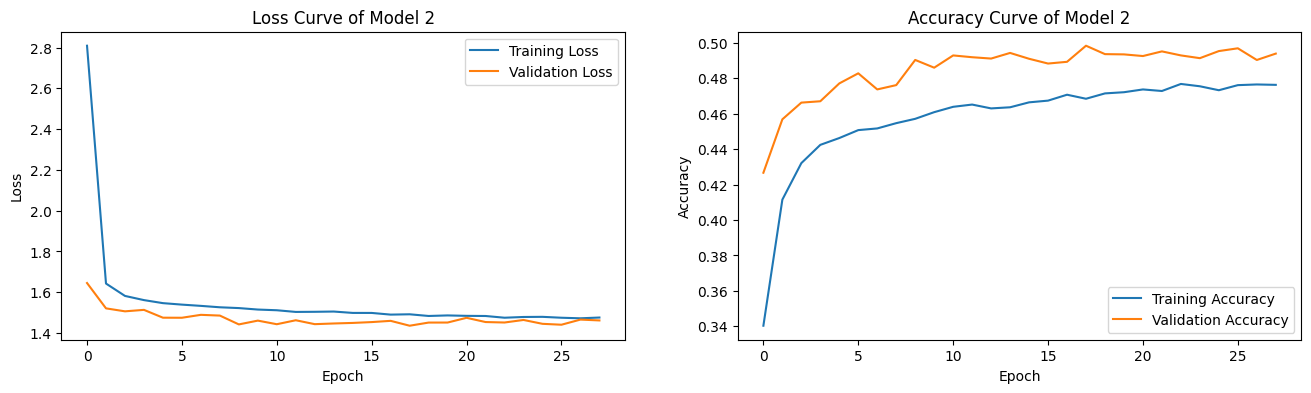

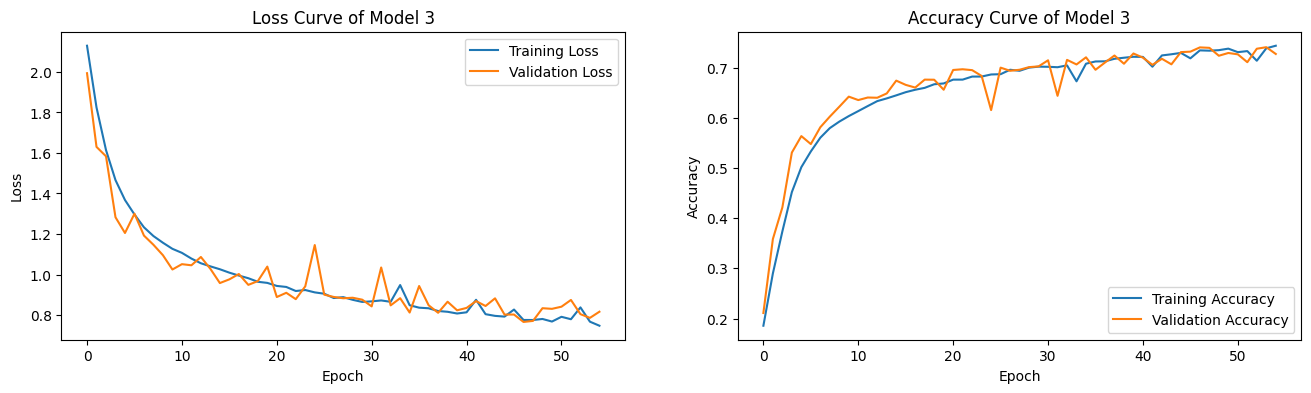

In [11]:

number_array = [1, 2, 3, 4]
hist_array = [history_1, history_2, history_3, history_4]


for i, history_i in zip(number_array, hist_array):
  fig = plt.figure(figsize=(16, 4))
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(history_i['loss'], label='Training Loss')
  ax1.plot(history_i['val_loss'], label='Validation Loss')
  ax1.set_title(f'Loss Curve of Model {i}')  # Changed 'ax.title' to 'ax1.set_title'
  ax1.set_xlabel('Epoch')  # Changed 'ax.xlabel' to 'ax1.set_xlabel'
  ax1.set_ylabel('Loss')  # Changed 'ax.ylabel' to 'ax1.set_ylabel'
  ax1.legend()

  # Create a new subplot for accuracy
  ax2 = fig.add_subplot(1, 2, 2)  # Added this line to create a new subplot for accuracy
  ax2.plot(history_i['accuracy'], label='Training Accuracy')
  ax2.plot(history_i['val_accuracy'], label='Validation Accuracy')
  ax2.set_title(f'Accuracy Curve of Model {i}')  # Changed 'ax2.title' to 'ax2.set_title'
  ax2.set_xlabel('Epoch')  # Changed 'ax2.xlabel' to 'ax2.set_xlabel'
  ax2.set_ylabel('Accuracy')  # Changed 'ax2.ylabel' to 'ax2.set_ylabel'
  ax2.legend()

  plt.show()  # Moved this line to display both subplots together


### Combined Graphs

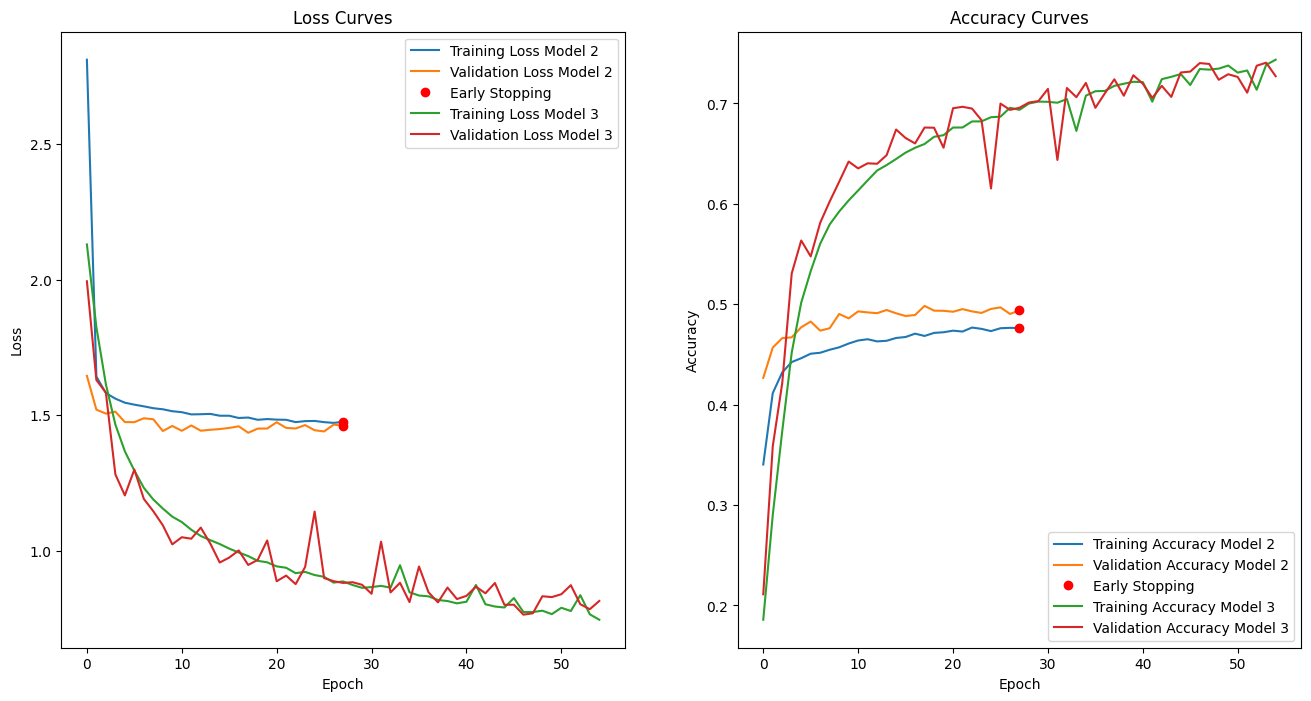

In [17]:

number_array = [1, 2, 3, 4]
hist_array = [history_1, history_2, history_3, history_4]

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

for i, history_i in zip(number_array, hist_array):
    # Plot training & validation loss values
    ax1.plot(history_i['loss'], label=f'Training Loss Model {i}')
    ax1.plot(history_i['val_loss'], label=f'Validation Loss Model {i}')

    # Plot training & validation accuracy values
    ax2.plot(history_i['accuracy'], label=f'Training Accuracy Model {i}')
    ax2.plot(history_i['val_accuracy'], label=f'Validation Accuracy Model {i}')

    # Annotate early stopping point for Model 2 with a prominent marker
    if i == 2:
        early_stopping_epoch = len(history_i['loss'])
        ax1.plot(early_stopping_epoch - 1, history_i['loss'][-1], 'ro', label='Early Stopping')
        ax1.plot(early_stopping_epoch - 1, history_i['val_loss'][-1], 'ro')

        ax2.plot(early_stopping_epoch - 1, history_i['accuracy'][-1], 'ro', label='Early Stopping')
        ax2.plot(early_stopping_epoch - 1, history_i['val_accuracy'][-1], 'ro')

ax1.legend()
ax2.legend()

plt.show()


### Testing the models

In [ ]:
# model_list = [vgg_model_1, vgg_model_2, vgg_model_3, vgg_model_4]
model_list = [vgg_model_3]
for model_i in model_list:
  loss, accuracy = model_i.evaluate(test_ds)
  print(f'Test Loss of Model{i}:', loss)
  print(f'Test Accuracy of Model{i}:', accuracy)


704/704 [==============================] - 37s 52ms/step - loss: 0.8265 - accuracy: 0.7262
Test Loss of Model1: 0.8265437483787537
Test Accuracy of Model1: 0.7261666655540466


In [ ]:
model_list = [vgg_model_1, vgg_model_2, vgg_model_3, vgg_model_4]

results = []
for i, model in enumerate(model_list):
    loss, accuracy = model.evaluate(test_ds)
    results.append([f'Model {i+1}', accuracy, loss])

print(tabulate(results, headers=['Model Name', 'Accuracy', 'Loss'], tablefmt='orgtbl'))
